## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [7]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [12]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


"""
建立神經網路，並加入 BN layer
"""
def build_mlp_before_activation(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


def build_mlp_after_input(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [13]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZES = [256, 128,64]
MOMENTUM = 0.95

In [14]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_SIZE in BATCH_SIZES:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    exp_name_tag = "BATCH_SIZE %s" %(BATCH_SIZE)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

50000/50000 [==============================] - 8s 167us/step - loss: 0.2378 - acc: 0.9290 - val_loss: 2.4220 - val_acc: 0.4475
Epoch 46/50
50000/50000 [==============================] - 8s 166us/step - loss: 0.2172 - acc: 0.9371 - val_loss: 2.4525 - val_acc: 0.4512
Epoch 47/50
50000/50000 [==============================] - 8s 166us/step - loss: 0.2075 - acc: 0.9402 - val_loss: 2.4292 - val_acc: 0.4577
Epoch 48/50
50000/50000 [==============================] - 8s 166us/step - loss: 0.1990 - acc: 0.9429 - val_loss: 2.5068 - val_acc: 0.4514
Epoch 49/50
50000/50000 [==============================] - 8s 167us/step - loss: 0.1920 - acc: 0.9444 - val_loss: 2.4445 - val_acc: 0.4606
Epoch 50/50
50000/50000 [==============================] - 8s 166us/step - loss: 0.1787 - acc: 0.9503 - val_loss: 2.4800 - val_acc: 0.4588
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)     

50000/50000 [==============================] - 12s 234us/step - loss: 0.3346 - acc: 0.8847 - val_loss: 2.3545 - val_acc: 0.4664
Epoch 44/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.3151 - acc: 0.8923 - val_loss: 2.4189 - val_acc: 0.4526
Epoch 45/50
50000/50000 [==============================] - 12s 233us/step - loss: 0.3139 - acc: 0.8929 - val_loss: 2.3668 - val_acc: 0.4621
Epoch 46/50
50000/50000 [==============================] - 12s 233us/step - loss: 0.2898 - acc: 0.9026 - val_loss: 2.3900 - val_acc: 0.4586
Epoch 47/50
50000/50000 [==============================] - 12s 231us/step - loss: 0.2841 - acc: 0.9049 - val_loss: 2.5583 - val_acc: 0.4475
Epoch 48/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.2948 - acc: 0.8981 - val_loss: 2.4542 - val_acc: 0.4755
Epoch 49/50
50000/50000 [==============================] - 12s 234us/step - loss: 0.2751 - acc: 0.9076 - val_loss: 2.6259 - val_acc: 0.4469
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 18s 357us/step - loss: 0.6002 - acc: 0.7870 - val_loss: 2.0703 - val_acc: 0.4590
Epoch 42/50
50000/50000 [==============================] - 18s 358us/step - loss: 0.5888 - acc: 0.7899 - val_loss: 1.8194 - val_acc: 0.4882
Epoch 43/50
50000/50000 [==============================] - 18s 367us/step - loss: 0.5759 - acc: 0.7967 - val_loss: 1.8954 - val_acc: 0.4815
Epoch 44/50
50000/50000 [==============================] - 18s 358us/step - loss: 0.5590 - acc: 0.8005 - val_loss: 1.9205 - val_acc: 0.4740
Epoch 45/50
50000/50000 [==============================] - 18s 360us/step - loss: 0.5497 - acc: 0.8041 - val_loss: 1.8798 - val_acc: 0.4909
Epoch 46/50
50000/50000 [==============================] - 18s 362us/step - loss: 0.5512 - acc: 0.8023 - val_loss: 2.1836 - val_acc: 0.4453
Epoch 47/50
50000/50000 [==============================] - 18s 358us/step - loss: 0.5287 - acc: 0.8116 - val_loss: 2.1092 - val_acc: 0.4705
Epoch 48/50
50000/50000 [=======

In [16]:
model = build_mlp_before_activation(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
exp_name_tag = "build_mlp_before_activation"
results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_11 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_12 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

50000/50000 [==============================] - 10s 200us/step - loss: 0.0421 - acc: 0.9943 - val_loss: 2.5329 - val_acc: 0.5086
Epoch 49/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.0374 - acc: 0.9952 - val_loss: 2.5380 - val_acc: 0.5109
Epoch 50/50
50000/50000 [==============================] - 10s 201us/step - loss: 0.0304 - acc: 0.9967 - val_loss: 2.5637 - val_acc: 0.5078


In [17]:
model = build_mlp_after_input(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=256, 
          validation_data=(x_test, y_test), 
          shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]
exp_name_tag = "build_mlp_after_input"
results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
__________

50000/50000 [==============================] - 10s 197us/step - loss: 0.0306 - acc: 0.9964 - val_loss: 2.6435 - val_acc: 0.5058
Epoch 50/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.0257 - acc: 0.9976 - val_loss: 2.6620 - val_acc: 0.5050


In [18]:
import pickle
f = open('results.bak', 'wb')
pickle.dump(results, f)

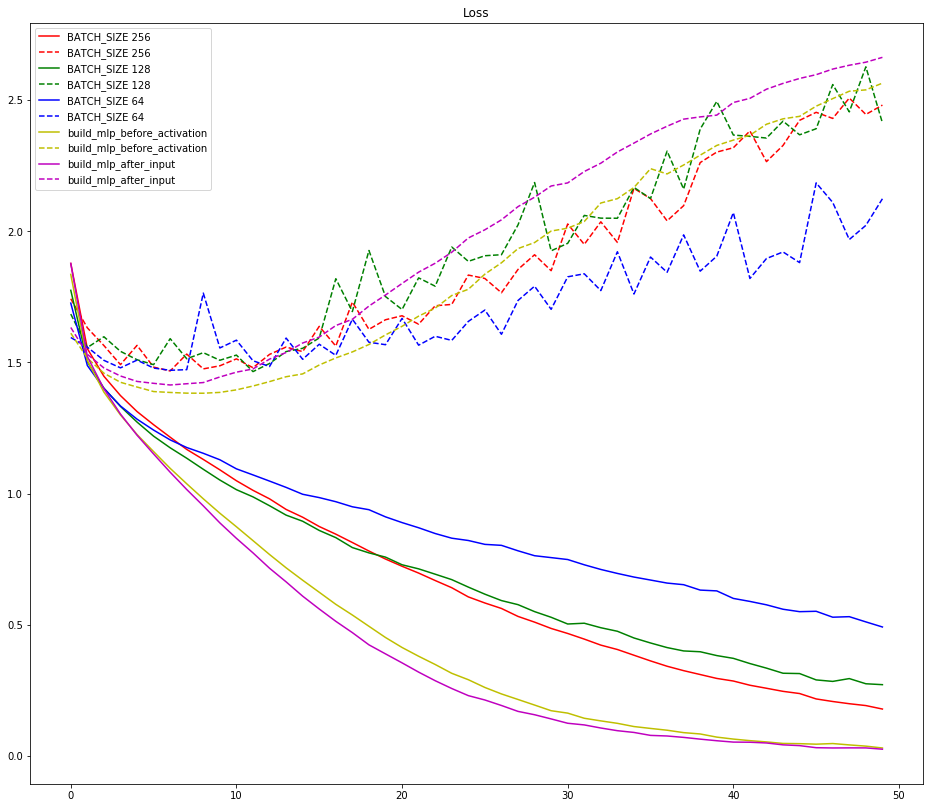

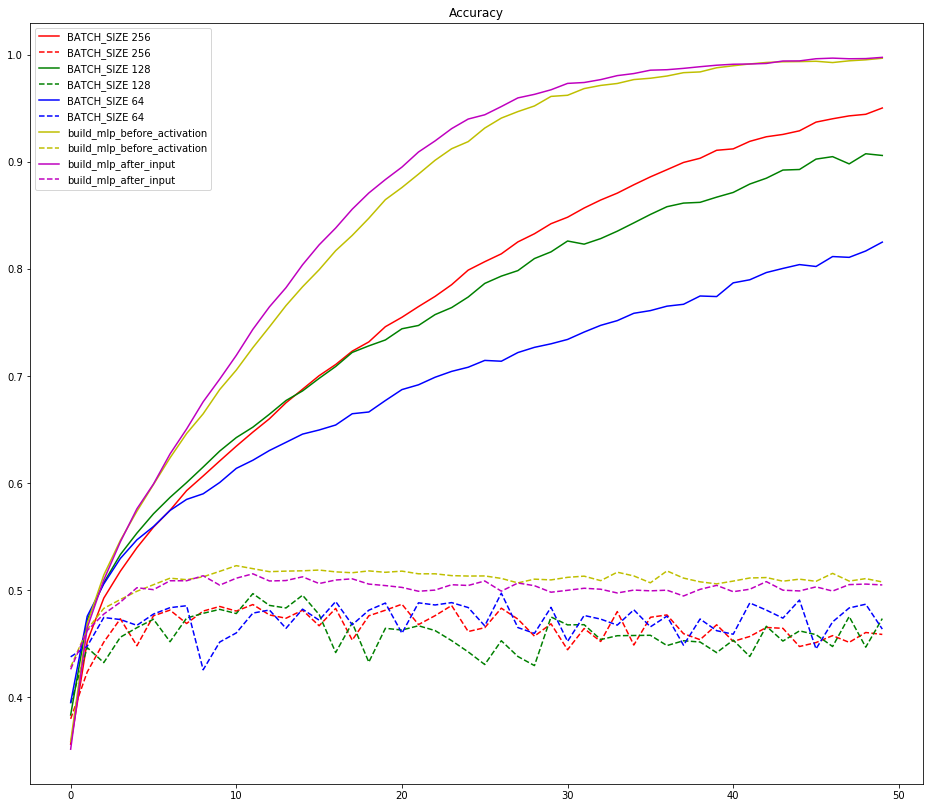

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",'c','coral']

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(16,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()